In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from keras import optimizers

Using TensorFlow backend.


In [2]:
def read_data(file_path):
    df = pd.read_csv(file_path, index_col=[0])
    # df['f1d_binary'] = np.where(df['f1d_label'] > 0, 1, 0)

    df_stock = df[df['minor'] == 'VMC'][['minor', 'Date', '0', '1', '2', 'f1d_label']]
    return df_stock


def create_segments_and_labels(df, time_steps, step, label_name):
    # Number of steps to advance in each iteration
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['0'].values[i: i + time_steps]
        ys = df['1'].values[i: i + time_steps]
        zs = df['2'].values[i: i + time_steps]

        # use last days f1d_binary as label
        label = df[label_name].values[i + time_steps - 1]

        # # for testing
        # from numpy import random
        # label = random.randint(2)

        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [8]:
root_folder = '/Users/kaiwang/bkup/har-keras-cnn/'

In [3]:
'''params'''
# n features
N_FEATURES = 3

# The number of steps within one time segment
TIME_PERIODS = 60
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 1

filter_height = 3
filter_depths = [2, 4, 8, 16]
drop_out = 0.5

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 600

In [9]:
df = read_data(root_folder + 'Data/temp_ret_3_30_stocks.csv')

# Define column name of the label vector
# LABEL = 'f1d_binary'
LABEL = 'f1d_label'

print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_test = df[df['Date'] > '2019-02-24T09:30:00Z']
df_train = df[df['Date'] <= '2019-02-24T09:30:00Z']

# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
# Displays (134, 80, 3)
print(x_train.shape[0], 'training samples')
# Displays 134 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (134,)


--- Reshape the data into segments ---


--- Reshape data to be accepted by Keras ---

('x_train shape: ', (5360, 60, 3))
(5360, 'training samples')
('y_train shape: ', (5360,))


In [10]:
# Set input & output dimensions
num_time_periods, num_features = x_train.shape[1], x_train.shape[2]
num_classes = 2

# Set input_shape / reshape for Keras
# todo: remove
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [80,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods * num_features)
x_train = x_train.reshape(x_train.shape[0], input_shape)

print('x_train shape:', x_train.shape)
# x_train shape: (20869, 240)
print('input_shape:', input_shape)
# input_shape: (240)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

('x_train shape:', (5360, 180))
('input_shape:', 180)


In [11]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_features), input_shape=(input_shape,)))  # 0
model_m.add(Conv1D(filter_depths[0], filter_height, activation='tanh', input_shape=(TIME_PERIODS, num_features)))  # 1
model_m.add(Conv1D(filter_depths[1], filter_height, activation='tanh'))  # 2
# model_m.add(MaxPooling1D(3))
model_m.add(AveragePooling1D(N_FEATURES))  # 3
model_m.add(Conv1D(filter_depths[2], filter_height, activation='tanh'))  # 4
model_m.add(Conv1D(filter_depths[3], filter_height, activation='tanh'))  # 5
model_m.add(GlobalAveragePooling1D())  # 6
model_m.add(Dropout(drop_out))  # 7
model_m.add(Dense(1))  # 8
print(model_m.summary())

model_m.compile(optimizer=optimizers.Adam(lr=1e-04), loss='mean_squared_error')

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=root_folder + 'models_regression/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=3)
]

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


--- Create neural network model ---

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 60, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 58, 2)             20        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 56, 4)             28        
_________________________________________________________________
average_pooling1d_2 (Average (None, 18, 4)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 16, 8)             104       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 14, 16)            400       
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16

/Users/kaiwang/venv/lib/python2.7/site-packages/keras/callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,val_loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4288/4288 [==============================] - 0s 27us/step - loss: 1.5224e-05 - val_loss: 3.5906e-06
Epoch 4/600
4288/4288 [==============================] - 0s 25us/step - loss: 1.5147e-05 - val_loss: 3.5510e-06
Epoch 5/600
4288/4288 [==============================] - 0s 23us/step - loss: 1.5251e-05 - val_loss: 3.5588e-06
Epoch 6/600
4288/4288 [==============================] - 0s 24us/step - loss: 1.5273e-05 - val_loss: 3.5374e-06
Epoch 7/600
4288/4288 [==============================] - 0s 23us/step - loss: 1.5258e-05 - val_loss: 3.5794e-06
Epoch 8/600
4288/4288 [==============================] - 0s 31us/step - loss: 1.5194e-05 - val_loss: 3.5724e-06
Epoch 9/600
4288/4288 [==============================] - 0s 32us/step - loss: 1.5214e-05 - val_loss: 3.6022e-06
Epoch 10/600
4288/4288 [==============================] - 0s 30us/step - loss: 1.5190e-05 - val_loss: 3.5895e-06
Epoch 11/600
4288/4288 [==============================] - 0s 28us/step - loss: 1.5282e-05 - val_loss: 3.7005e-06
Ep

4288/4288 [==============================] - 0s 26us/step - loss: 1.5170e-05 - val_loss: 3.6658e-06
Epoch 76/600
4288/4288 [==============================] - 0s 26us/step - loss: 1.5164e-05 - val_loss: 3.6639e-06
Epoch 77/600
4288/4288 [==============================] - 0s 28us/step - loss: 1.5232e-05 - val_loss: 3.5520e-06
Epoch 78/600
4288/4288 [==============================] - 0s 25us/step - loss: 1.5308e-05 - val_loss: 3.5527e-06
Epoch 79/600
4288/4288 [==============================] - 0s 24us/step - loss: 1.5361e-05 - val_loss: 3.5411e-06
Epoch 80/600
4288/4288 [==============================] - 0s 24us/step - loss: 1.5264e-05 - val_loss: 3.5693e-06
Epoch 81/600
4288/4288 [==============================] - 0s 23us/step - loss: 1.5123e-05 - val_loss: 3.6041e-06
Epoch 82/600
4288/4288 [==============================] - 0s 24us/step - loss: 1.5218e-05 - val_loss: 3.7602e-06
Epoch 83/600
4288/4288 [==============================] - 0s 27us/step - loss: 1.5154e-05 - val_loss: 3.7032e

4288/4288 [==============================] - 0s 19us/step - loss: 1.5236e-05 - val_loss: 3.6574e-06
Epoch 148/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5203e-05 - val_loss: 3.7769e-06
Epoch 149/600
4288/4288 [==============================] - 0s 20us/step - loss: 1.5208e-05 - val_loss: 3.9080e-06
Epoch 150/600
4288/4288 [==============================] - 0s 28us/step - loss: 1.5135e-05 - val_loss: 3.6719e-06
Epoch 151/600
4288/4288 [==============================] - 0s 26us/step - loss: 1.5128e-05 - val_loss: 3.7373e-06
Epoch 152/600
4288/4288 [==============================] - 0s 24us/step - loss: 1.5122e-05 - val_loss: 3.6241e-06
Epoch 153/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5188e-05 - val_loss: 3.5496e-06
Epoch 154/600
4288/4288 [==============================] - 0s 21us/step - loss: 1.5119e-05 - val_loss: 3.5562e-06
Epoch 155/600
4288/4288 [==============================] - 0s 20us/step - loss: 1.5169e-05 - val_loss:

Epoch 219/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5187e-05 - val_loss: 3.6984e-06
Epoch 220/600
4288/4288 [==============================] - 0s 22us/step - loss: 1.5174e-05 - val_loss: 3.7798e-06
Epoch 221/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5198e-05 - val_loss: 4.0223e-06
Epoch 222/600
4288/4288 [==============================] - 0s 20us/step - loss: 1.5210e-05 - val_loss: 3.5672e-06
Epoch 223/600
4288/4288 [==============================] - 0s 21us/step - loss: 1.5145e-05 - val_loss: 3.5622e-06
Epoch 224/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5172e-05 - val_loss: 3.5879e-06
Epoch 225/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5238e-05 - val_loss: 3.7271e-06
Epoch 226/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5153e-05 - val_loss: 3.6913e-06
Epoch 227/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5121e-

Epoch 291/600
4288/4288 [==============================] - 0s 27us/step - loss: 1.5174e-05 - val_loss: 3.6768e-06
Epoch 292/600
4288/4288 [==============================] - 0s 25us/step - loss: 1.5120e-05 - val_loss: 3.6652e-06
Epoch 293/600
4288/4288 [==============================] - 0s 25us/step - loss: 1.5168e-05 - val_loss: 3.6685e-06
Epoch 294/600
4288/4288 [==============================] - 0s 22us/step - loss: 1.5101e-05 - val_loss: 3.8503e-06
Epoch 295/600
4288/4288 [==============================] - 0s 23us/step - loss: 1.5124e-05 - val_loss: 3.7334e-06
Epoch 296/600
4288/4288 [==============================] - 0s 22us/step - loss: 1.5174e-05 - val_loss: 3.7218e-06
Epoch 297/600
4288/4288 [==============================] - 0s 24us/step - loss: 1.5143e-05 - val_loss: 3.7058e-06
Epoch 298/600
4288/4288 [==============================] - 0s 26us/step - loss: 1.5150e-05 - val_loss: 3.6428e-06
Epoch 299/600
4288/4288 [==============================] - 0s 25us/step - loss: 1.5120e-

Epoch 363/600
4288/4288 [==============================] - 0s 20us/step - loss: 1.5274e-05 - val_loss: 3.5930e-06
Epoch 364/600
4288/4288 [==============================] - 0s 25us/step - loss: 1.5240e-05 - val_loss: 3.7266e-06
Epoch 365/600
4288/4288 [==============================] - 0s 30us/step - loss: 1.5190e-05 - val_loss: 3.7869e-06
Epoch 366/600
4288/4288 [==============================] - 0s 22us/step - loss: 1.5095e-05 - val_loss: 3.6728e-06
Epoch 367/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5143e-05 - val_loss: 3.5643e-06
Epoch 368/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5144e-05 - val_loss: 3.6486e-06
Epoch 369/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5147e-05 - val_loss: 3.7825e-06
Epoch 370/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5146e-05 - val_loss: 3.6971e-06
Epoch 371/600
4288/4288 [==============================] - 0s 20us/step - loss: 1.5127e-

Epoch 435/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5110e-05 - val_loss: 3.6244e-06
Epoch 436/600
4288/4288 [==============================] - 0s 21us/step - loss: 1.5095e-05 - val_loss: 3.5420e-06
Epoch 437/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5197e-05 - val_loss: 3.9868e-06
Epoch 438/600
4288/4288 [==============================] - 0s 20us/step - loss: 1.5265e-05 - val_loss: 4.1968e-06
Epoch 439/600
4288/4288 [==============================] - 0s 21us/step - loss: 1.5286e-05 - val_loss: 3.6634e-06
Epoch 440/600
4288/4288 [==============================] - 0s 23us/step - loss: 1.5167e-05 - val_loss: 3.5827e-06
Epoch 441/600
4288/4288 [==============================] - 0s 26us/step - loss: 1.5392e-05 - val_loss: 3.5398e-06
Epoch 442/600
4288/4288 [==============================] - 0s 25us/step - loss: 1.5246e-05 - val_loss: 4.2647e-06
Epoch 443/600
4288/4288 [==============================] - 0s 22us/step - loss: 1.5266e-

Epoch 507/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5140e-05 - val_loss: 3.5448e-06
Epoch 508/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5186e-05 - val_loss: 3.6732e-06
Epoch 509/600
4288/4288 [==============================] - 0s 20us/step - loss: 1.5166e-05 - val_loss: 3.6520e-06
Epoch 510/600
4288/4288 [==============================] - 0s 21us/step - loss: 1.5135e-05 - val_loss: 3.7196e-06
Epoch 511/600
4288/4288 [==============================] - 0s 21us/step - loss: 1.5159e-05 - val_loss: 3.5737e-06
Epoch 512/600
4288/4288 [==============================] - 0s 20us/step - loss: 1.5138e-05 - val_loss: 3.6028e-06
Epoch 513/600
4288/4288 [==============================] - 0s 19us/step - loss: 1.5180e-05 - val_loss: 3.5389e-06
Epoch 514/600
4288/4288 [==============================] - 0s 20us/step - loss: 1.5148e-05 - val_loss: 3.7306e-06
Epoch 515/600
4288/4288 [==============================] - 0s 20us/step - loss: 1.5187e-

Epoch 579/600
4288/4288 [==============================] - 0s 25us/step - loss: 1.5198e-05 - val_loss: 3.5725e-06
Epoch 580/600
4288/4288 [==============================] - 0s 23us/step - loss: 1.5147e-05 - val_loss: 3.5578e-06
Epoch 581/600
4288/4288 [==============================] - 0s 23us/step - loss: 1.5143e-05 - val_loss: 3.7063e-06
Epoch 582/600
4288/4288 [==============================] - 0s 23us/step - loss: 1.5160e-05 - val_loss: 3.6708e-06
Epoch 583/600
4288/4288 [==============================] - 0s 23us/step - loss: 1.5217e-05 - val_loss: 3.8501e-06
Epoch 584/600
4288/4288 [==============================] - 0s 23us/step - loss: 1.5135e-05 - val_loss: 3.6840e-06
Epoch 585/600
4288/4288 [==============================] - 0s 24us/step - loss: 1.5144e-05 - val_loss: 3.5847e-06
Epoch 586/600
4288/4288 [==============================] - 0s 24us/step - loss: 1.5170e-05 - val_loss: 3.9394e-06
Epoch 587/600
4288/4288 [==============================] - 0s 28us/step - loss: 1.5251e-

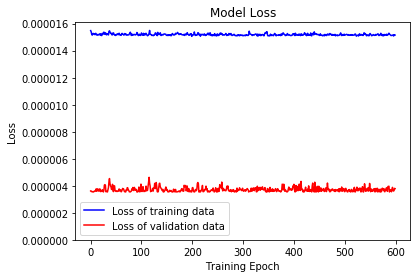

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], "b", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()

In [13]:
print(model_m.layers)

# print ('\ncheck layer before softmax output')
layer_models = []
for i in range(len(model_m.layers)):
    layer_models.append(Model(inputs=model_m.input, outputs=model_m.layers[i].output))

[<keras.layers.core.Reshape object at 0x114cba690>, <keras.layers.convolutional.Conv1D object at 0x114b8eed0>, <keras.layers.convolutional.Conv1D object at 0x114b8ee90>, <keras.layers.pooling.AveragePooling1D object at 0x114b8ee50>, <keras.layers.convolutional.Conv1D object at 0x114b8ecd0>, <keras.layers.convolutional.Conv1D object at 0x114b52b90>, <keras.layers.pooling.GlobalAveragePooling1D object at 0x114cba3d0>, <keras.layers.core.Dropout object at 0x114bc9990>, <keras.layers.core.Dense object at 0x114bd99d0>]


In [15]:
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
# todo: remove
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

score = model_m.evaluate(x_test, y_test, verbose=1)

print('score:')
print(score)

y_pred_test = model_m.predict(x_test)

1880/1880 [==============================] - 0s 35us/step
score:
5.233651405007472e-06


(array([  7.,  25., 123., 593., 770., 230.,  79.,  42.,   8.,   3.]),
 array([0.00027889, 0.00030161, 0.00032434, 0.00034706, 0.00036978,
        0.0003925 , 0.00041523, 0.00043795, 0.00046067, 0.0004834 ,
        0.00050612]),
 <a list of 10 Patch objects>)

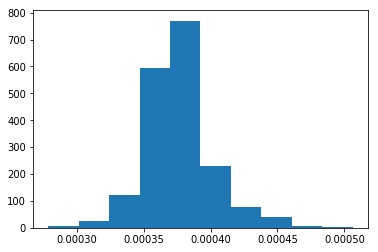

In [17]:
plt.hist(y_pred_test)

(array([1.000e+00, 1.000e+00, 1.380e+02, 5.113e+03, 9.500e+01, 2.000e+00,
        2.000e+00, 6.000e+00, 1.000e+00, 1.000e+00]),
 array([-0.04053565, -0.02866469, -0.01679374, -0.00492278,  0.00694817,
         0.01881913,  0.03069009,  0.04256104,  0.054432  ,  0.06630296,
         0.07817391]),
 <a list of 10 Patch objects>)

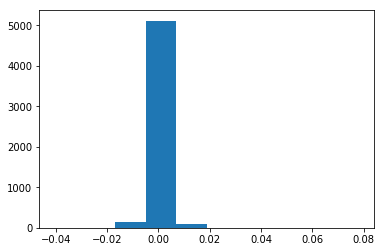

In [18]:
plt.hist(y_train)

In [19]:
y_pred_train = model_m.predict(x_train)

(array([1.00e+00, 0.00e+00, 2.00e+00, 6.00e+00, 2.00e+02, 4.79e+03,
        3.41e+02, 1.40e+01, 4.00e+00, 2.00e+00]),
 array([-1.54617213e-04, -6.02322834e-05,  3.41526465e-05,  1.28537577e-04,
         2.22922507e-04,  3.17307436e-04,  4.11692366e-04,  5.06077296e-04,
         6.00462226e-04,  6.94847156e-04,  7.89232086e-04]),
 <a list of 10 Patch objects>)

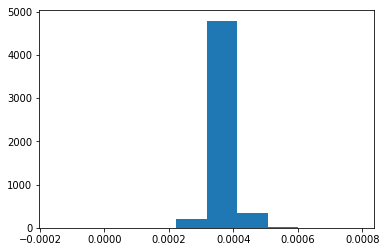

In [20]:
plt.hist(y_pred_train)